Deep Learning with TensorFlow
=============

Credits: Forked from [TensorFlow](https://github.com/tensorflow/tensorflow) by Google

Setup
------------

Refer to the [setup instructions](https://github.com/donnemartin/data-science-ipython-notebooks/tree/feature/deep-learning/deep-learning/tensor-flow-exercises/README.md).

Exercise 5
------------

The goal of this exercise is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [7]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import urllib.request
import zipfile
from matplotlib import pylab
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [8]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print ('Found and verified', filename)
  else:
    print (statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [9]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return f.read(name).split()
  f.close()
  
words = read_data(filename)
print ('Data size', len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [10]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print ('Most common words (+UNK)', count[:5])
print ('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], (b'the', 1061396), (b'of', 593677), (b'and', 416629), (b'one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [12]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(int(batch_size / num_skips)):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print (batch[i], '->', labels[i, 0])
  print (reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]])

3081 -> 12
b'originated' -> b'as'
3081 -> 5234
b'originated' -> b'anarchism'
12 -> 3081
b'as' -> b'originated'
12 -> 6
b'as' -> b'a'
6 -> 195
b'a' -> b'term'
6 -> 12
b'a' -> b'as'
195 -> 6
b'term' -> b'a'
195 -> 2
b'term' -> b'of'


Train a skip-gram model.

In [22]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, labels=train_labels,
                                inputs=embed, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [24]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print ("Initialized")
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 5000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print ("Average loss at step", step, ":", average_loss)
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = "Nearest to %s:" % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print (log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0 : 8.2585439682
Nearest to b'use': b'subscript', b'infect', b'interviewed', b'bedford', b'burgeoning', b'unison', b'homework', b'cristobal',
Nearest to b'there': b'practice', b'habilis', b'shuffling', b'yokoi', b'flare', b'lantern', b'corporatist', b'vivre',
Nearest to b'be': b'melanesia', b'pointless', b'radiotelephone', b'gyroscopic', b'sergio', b'theaters', b'turks', b'exposition',
Nearest to b'seven': b'moraines', b'yam', b'heliogabalus', b'omnipotence', b'victim', b'sempronius', b'forti', b'tanistry',
Nearest to b'with': b'balaenoptera', b'indomitable', b'redistribute', b'fronted', b'folie', b'cahill', b'hb', b'saboteurs',
Nearest to b'when': b'tenji', b'smack', b'dwell', b'falsely', b'authorizing', b'implemented', b'themis', b'renouncing',
Nearest to b'new': b'xof', b'codon', b'loci', b'launchers', b'click', b'observables', b'nymphs', b'quine',
Nearest to b'would': b'factored', b'hbc', b'reaction', b'harlan', b'tsunami', b'smile', b'unalaska', b'

Average loss at step 45000 : 8.39025845879
Average loss at step 50000 : 8.58803341609
Nearest to b'use': b'study', b'explain', b'cost', b'need', b'asb', b'exothermic', b'kana', b'end',
Nearest to b'there': b'they', b'it', b'he', b'we', b'now', b'still', b'usually', b'she',
Nearest to b'be': b'been', b'have', b'become', b'refer', b'were', b'is', b'being', b'was',
Nearest to b'seven': b'eight', b'six', b'four', b'five', b'nine', b'three', b'zero', b'two',
Nearest to b'with': b'between', b'by', b'in', b'among', b'pico', b'when', b'using', b'decedent',
Nearest to b'when': b'if', b'before', b'after', b'during', b'although', b'because', b'since', b'while',
Nearest to b'new': b'cosmetic', b'demographic', b'wide', b'academic', b'dyed', b'layoffs', b'sexton', b'intensively',
Nearest to b'would': b'will', b'could', b'can', b'may', b'should', b'might', b'must', b'did',
Nearest to b'years': b'days', b'year', b'minutes', b'times', b'months', b'substandard', b'etienne', b'reactance',
Nearest to b'an

Average loss at step 95000 : 7.3430511992
Average loss at step 100000 : 8.06467613637
Nearest to b'use': b'ability', b'cost', b'sense', b'darkness', b'replica', b'exothermic', b'study', b'speakers',
Nearest to b'there': b'it', b'they', b'he', b'she', b'still', b'we', b'generally', b'now',
Nearest to b'be': b'been', b'become', b'being', b'was', b'have', b'is', b'were', b'refer',
Nearest to b'seven': b'eight', b'six', b'nine', b'four', b'five', b'three', b'zero', b'two',
Nearest to b'with': b'between', b'by', b'enjoys', b'among', b'reflexes', b'hb', b'booker', b'timetable',
Nearest to b'when': b'if', b'before', b'while', b'after', b'though', b'where', b'although', b'because',
Nearest to b'new': b'modern', b'benchmarks', b'wide', b'demographic', b'old', b'karim', b'radiocommunication', b'cosmetic',
Nearest to b'would': b'could', b'will', b'might', b'can', b'should', b'must', b'may', b'cannot',
Nearest to b'years': b'days', b'year', b'months', b'weeks', b'decades', b'minutes', b'centuries'

In [25]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

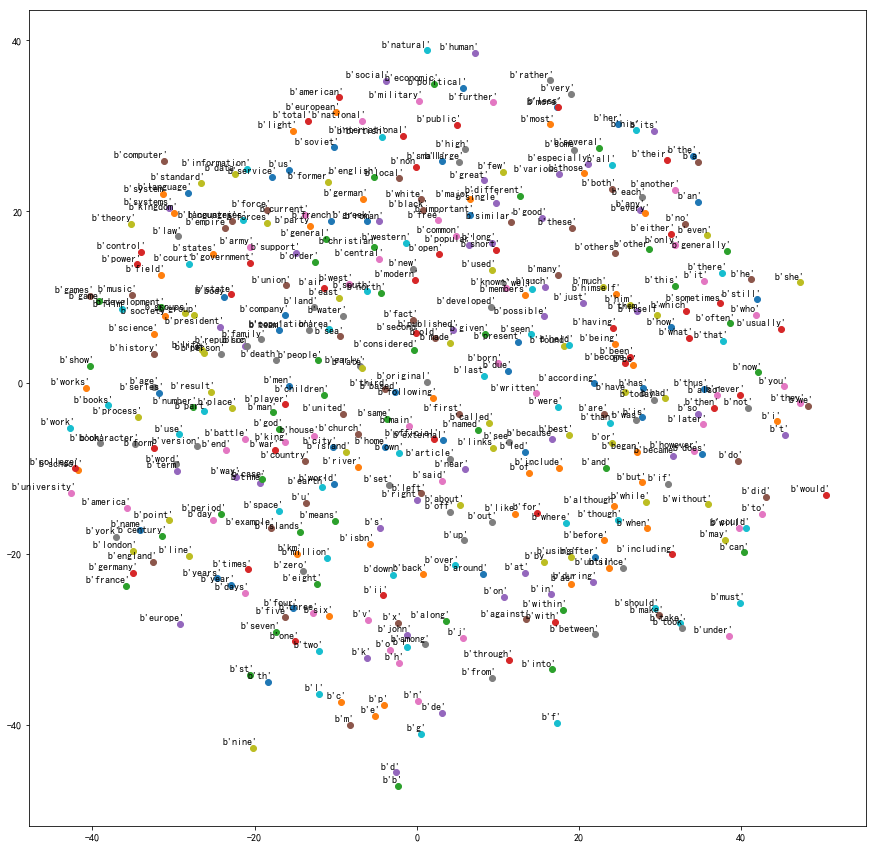

In [26]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)